In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# P11.1
Implement simulation of SIS model on ER graph. Compare
results with our analytical findings. [2P]


In [3]:
def simulate_sis_er(
        N=2000,
        p=0.01,
        beta=0.03,
        gamma=0.02,
        i0=0.01,
        T=300,
        seed=42
):

    rng = np.random.default_rng(seed)


    G = nx.erdos_renyi_graph(N, p, seed=seed)
    A = nx.to_scipy_sparse_array(G, format="csr")

    degrees = np.array(A.sum(axis=1)).reshape(-1)
    k_mean = degrees.mean()

    state = np.zeros(N, dtype=int)
    init_inf = rng.choice(N, size=max(1, int(i0 * N)), replace=False)
    state[init_inf] = 1

    infected_frac = np.zeros(T + 1)
    infected_frac[0] = state.mean()

    for t in range(1, T + 1):
        infected = state == 1
        susceptible = ~infected

        m = A @ infected.astype(int)
        m = np.asarray(m).reshape(-1)

        p_inf = 1.0 - (1.0 - beta) ** m

        new_state = state.copy()

        r1 = rng.random(N)
        new_state[susceptible & (r1 < p_inf)] = 1

        r2 = rng.random(N)
        new_state[infected & (r2 < gamma)] = 0

        state = new_state
        infected_frac[t] = state.mean()

    return infected_frac, k_mean

In [5]:
def mean_field_threshold(k_mean):
    return 1.0 / k_mean

def mean_field_endemic_level(beta, gamma, k_mean):
    lam = beta / gamma
    i_inf = 1.0 - 1.0 / (lam * k_mean)
    return max(0.0, i_inf)



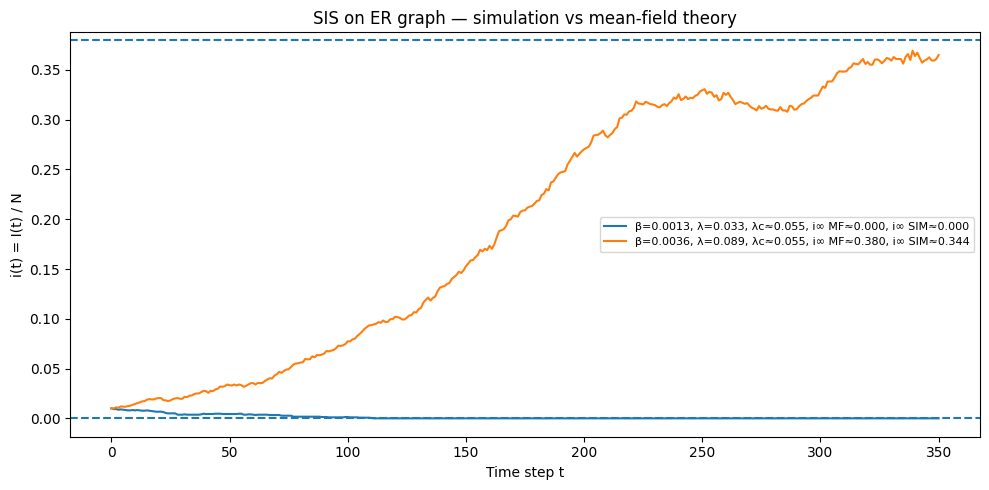

In [4]:
N = 3000
p = 0.006

gamma = 0.04
i0 = 0.01
T = 350
seed = 7

k_expected = p * (N - 1)
beta_c_est = gamma / k_expected

betas = [
    0.6 * beta_c_est,
    1.6 * beta_c_est
]

plt.figure(figsize=(10, 5))

for beta in betas:
    infected_frac, k_mean = simulate_sis_er(
        N=N, p=p, beta=beta, gamma=gamma, i0=i0, T=T, seed=seed
    )

    lam = beta / gamma
    lam_c = mean_field_threshold(k_mean)
    i_inf_mf = mean_field_endemic_level(beta, gamma, k_mean)

    i_inf_sim = infected_frac[int(0.8 * T):].mean()

    label = (
        f"β={beta:.4f}, λ={lam:.3f}, "
        f"λc≈{lam_c:.3f}, "
        f"i∞ MF≈{i_inf_mf:.3f}, "
        f"i∞ SIM≈{i_inf_sim:.3f}"
    )

    plt.plot(infected_frac, label=label)
    plt.axhline(i_inf_mf, linestyle="--")

plt.xlabel("Time step t")
plt.ylabel("i(t) = I(t) / N")
plt.title("SIS on ER graph — simulation vs mean-field theory")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


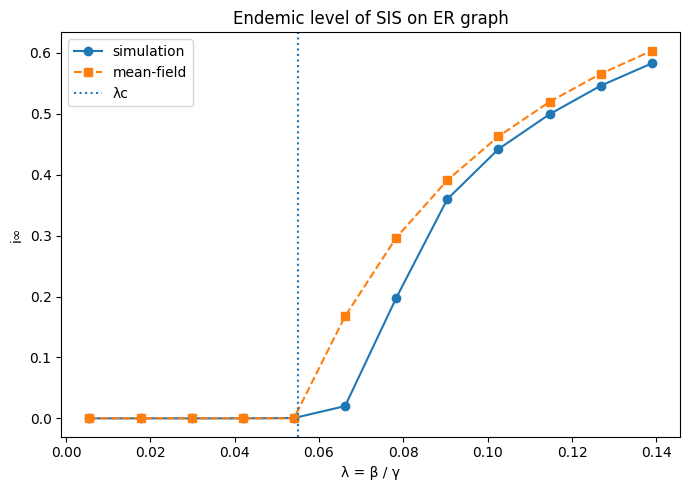

In [6]:
betas = np.linspace(0.1 * beta_c_est, 2.5 * beta_c_est, 12)

i_sim, i_mf, lambdas = [], [], []

for beta in betas:
    infected_frac, k_mean = simulate_sis_er(
        N=N, p=p, beta=beta, gamma=gamma, i0=i0, T=T, seed=seed
    )

    i_sim.append(infected_frac[int(0.8 * T):].mean())
    i_mf.append(mean_field_endemic_level(beta, gamma, k_mean))
    lambdas.append(beta / gamma)

plt.figure(figsize=(7, 5))
plt.plot(lambdas, i_sim, "o-", label="simulation")
plt.plot(lambdas, i_mf, "s--", label="mean-field")
plt.axvline(mean_field_threshold(k_mean), linestyle=":", label="λc")
plt.xlabel("λ = β / γ")
plt.ylabel("i∞")
plt.title("Endemic level of SIS on ER graph")
plt.legend()
plt.tight_layout()
plt.show()


# P11.2
 Implement simulation of SIS model on BA networks. Compare
results with our analytical findings. [2P]


In [7]:
def simulate_sis_on_graph(
    G,
    beta=0.03,
    gamma=0.02,
    i0=0.01,
    T=300,
    seed=42
):
    rng = np.random.default_rng(seed)

    N = G.number_of_nodes()
    A = nx.to_scipy_sparse_array(G, format="csr")

    degrees = np.array(A.sum(axis=1)).reshape(-1)
    k_mean = degrees.mean()
    k2_mean = (degrees**2).mean()

    state = np.zeros(N, dtype=int)
    initial_infected = rng.choice(N, size=max(1, int(i0 * N)), replace=False)
    state[initial_infected] = 1

    infected_fraction = np.zeros(T + 1)
    infected_fraction[0] = state.mean()

    for t in range(1, T + 1):
        infected = state == 1
        susceptible = ~infected

        m = A @ infected.astype(int)
        m = np.asarray(m).reshape(-1)

        p_infection = 1.0 - (1.0 - beta) ** m

        new_state = state.copy()

        r1 = rng.random(N)
        new_state[susceptible & (r1 < p_infection)] = 1

        r2 = rng.random(N)
        new_state[infected & (r2 < gamma)] = 0

        state = new_state
        infected_fraction[t] = state.mean()

    return infected_fraction, k_mean, k2_mean


In [8]:
def make_ba_graph(N=3000, m=3, seed=1):
    return nx.barabasi_albert_graph(N, m, seed=seed)


In [9]:
def lambda_c_scale_free(k_mean, k2_mean):
    return k_mean / k2_mean

def endemic_level_mf_er_like(beta, gamma, k_mean):
    lam = beta / gamma
    i_inf = 1.0 - 1.0 / (lam * k_mean)
    return max(0.0, i_inf)

<k> ≈ 5.994, <k^2> ≈ 99.228
Predicted λc = <k>/<k^2> ≈ 0.06041
Predicted βc = λc * γ ≈ 0.00242


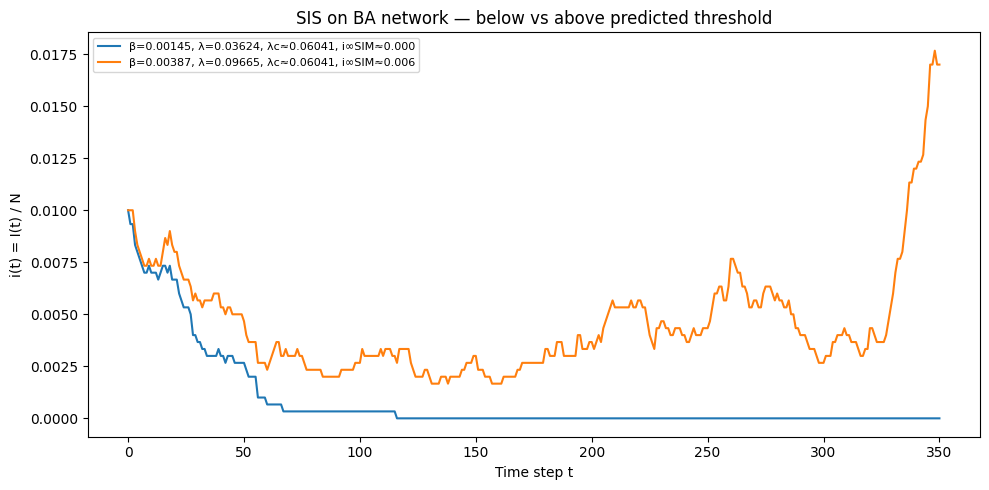

In [10]:
N = 3000
m = 3
G = make_ba_graph(N=N, m=m, seed=10)

gamma = 0.04
i0 = 0.01
T = 350
seed = 7

infected_frac0, k_mean, k2_mean = simulate_sis_on_graph(G, beta=0.0, gamma=gamma, i0=i0, T=0, seed=seed)
lam_c = lambda_c_scale_free(k_mean, k2_mean)
beta_c_est = lam_c * gamma

print(f"<k> ≈ {k_mean:.3f}, <k^2> ≈ {k2_mean:.3f}")
print(f"Predicted λc = <k>/<k^2> ≈ {lam_c:.5f}")
print(f"Predicted βc = λc * γ ≈ {beta_c_est:.5f}")

betas = [
    0.6 * beta_c_est,
    1.6 * beta_c_est
]

plt.figure(figsize=(10, 5))

for beta in betas:
    infected_frac, k_mean, k2_mean = simulate_sis_on_graph(
        G, beta=beta, gamma=gamma, i0=i0, T=T, seed=seed
    )
    lam = beta / gamma

    i_inf_sim = infected_frac[int(0.8 * T):].mean()

    label = f"β={beta:.5f}, λ={lam:.5f}, λc≈{lam_c:.5f}, i∞SIM≈{i_inf_sim:.3f}"
    plt.plot(infected_frac, label=label)

plt.xlabel("Time step t")
plt.ylabel("i(t) = I(t) / N")
plt.title("SIS on BA network — below vs above predicted threshold")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


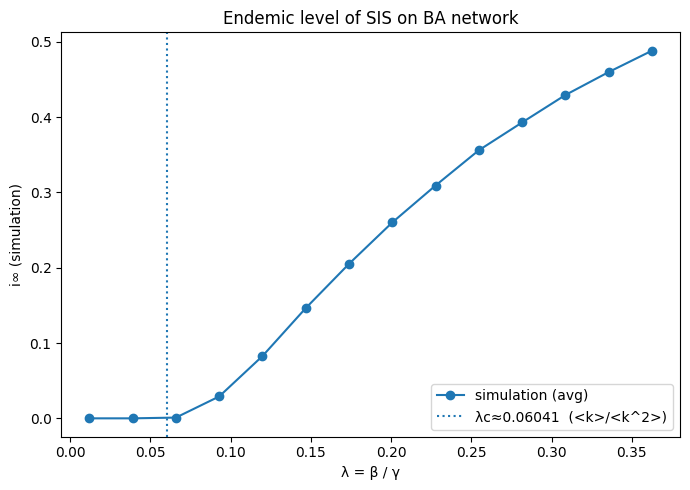

In [11]:
lams = np.linspace(0.2 * lam_c, 6.0 * lam_c, 14)
trials = 5

i_inf_sim_list = []

for lam in lams:
    beta = lam * gamma
    vals = []
    for tr in range(trials):
        infected_frac, _, _ = simulate_sis_on_graph(
            G, beta=beta, gamma=gamma, i0=i0, T=T, seed=1000 + 17*tr
        )
        vals.append(infected_frac[int(0.8 * T):].mean())
    i_inf_sim_list.append(float(np.mean(vals)))

plt.figure(figsize=(7, 5))
plt.plot(lams, i_inf_sim_list, "o-", label="simulation (avg)")
plt.axvline(lam_c, linestyle=":", label=f"λc≈{lam_c:.5f}  (<k>/<k^2>)")
plt.xlabel("λ = β / γ")
plt.ylabel("i∞ (simulation)")
plt.title("Endemic level of SIS on BA network")
plt.legend()
plt.tight_layout()
plt.show()


N= 1000: <k>=5.982, <k^2>=80.602, λc≈0.074217
N= 2000: <k>=5.991, <k^2>=88.787, λc≈0.067476
N= 4000: <k>=5.995, <k^2>=96.800, λc≈0.061937
N= 8000: <k>=5.998, <k^2>=105.843, λc≈0.056667


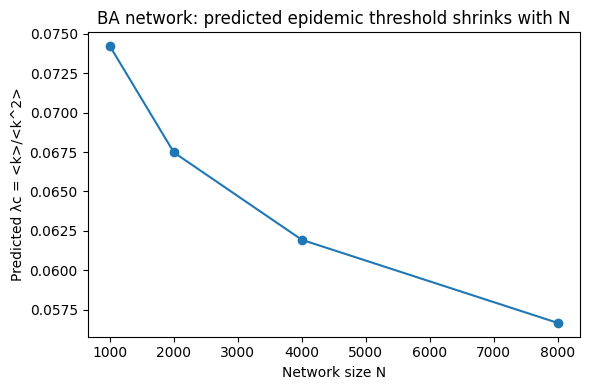

In [12]:
Ns = [1000, 2000, 4000, 8000]
m = 3

lamc_list = []

for N in Ns:
    G_tmp = make_ba_graph(N=N, m=m, seed=123)
    _, k_mean, k2_mean = simulate_sis_on_graph(G_tmp, beta=0.0, gamma=gamma, i0=i0, T=0, seed=1)
    lamc = lambda_c_scale_free(k_mean, k2_mean)
    lamc_list.append(lamc)
    print(f"N={N:5d}: <k>={k_mean:.3f}, <k^2>={k2_mean:.3f}, λc≈{lamc:.6f}")

plt.figure(figsize=(6, 4))
plt.plot(Ns, lamc_list, "o-")
plt.xlabel("Network size N")
plt.ylabel("Predicted λc = <k>/<k^2>")
plt.title("BA network: predicted epidemic threshold shrinks with N")
plt.tight_layout()
plt.show()


# P11.3
 Implement simulation of different than SIS agent-based model.
Discuss obtained results.

ER: consensus time = None
BA: consensus time = None


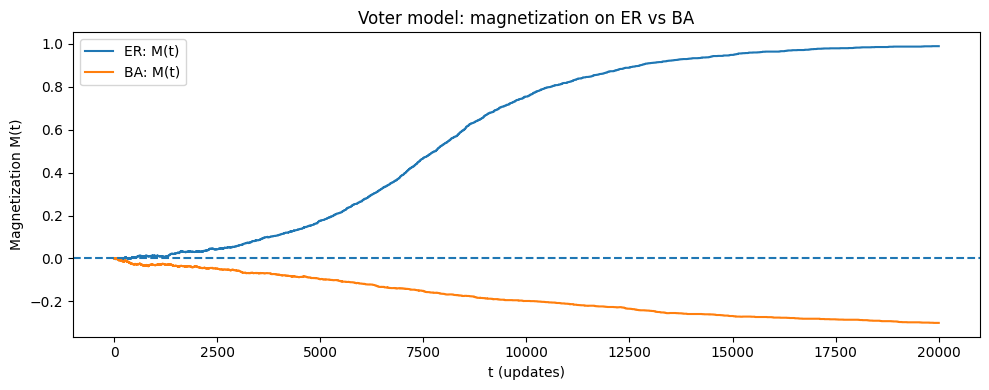

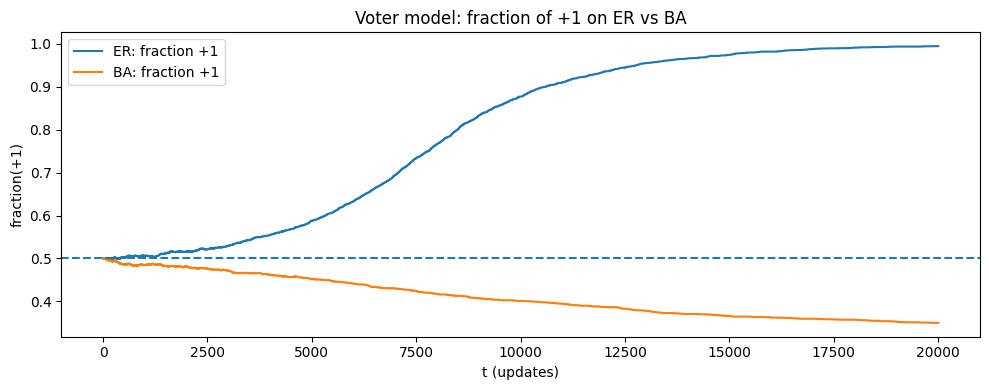

ER: mean consensus time (capped at T2) = 32274.8
BA: mean consensus time (capped at T2) = 49206.4


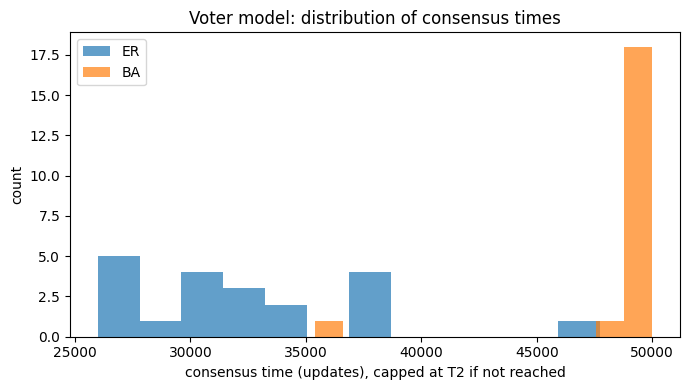

In [21]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def simulate_voter_model(
    G,
    T=20000,
    init_plus_frac=0.5,
    update_mode="async",
    tie_rule="keep",
    seed=42,
    return_states=False
):
    rng = np.random.default_rng(seed)

    N = G.number_of_nodes()
    nodes = np.array(list(G.nodes()))
    node_to_idx = {u: i for i, u in enumerate(nodes)}

    neigh = [np.array([node_to_idx[v] for v in G.neighbors(u)], dtype=int) for u in nodes]

    state = np.full(N, -1, dtype=np.int8)
    n_plus = max(1, int(round(init_plus_frac * N)))
    plus_idx = rng.choice(N, size=n_plus, replace=False)
    state[plus_idx] = 1

    def magnetization(x):
        return x.mean()

    steps = T
    M = np.empty(steps + 1, dtype=float)
    frac_plus = np.empty(steps + 1, dtype=float)

    M[0] = magnetization(state)
    frac_plus[0] = (state == 1).mean()

    def is_consensus(x):
        s = x.sum()
        return (s == N) or (s == -N)

    t_consensus = 0 if is_consensus(state) else None

    if update_mode not in {"async", "sweep"}:
        raise ValueError("update_mode must be 'async' or 'sweep'")

    t = 0
    for step in range(1, steps + 1):
        if update_mode == "async":
            i = rng.integers(0, N)
            nb = neigh[i]
            if nb.size > 0:
                m = int(state[nb].sum())
                if m > 0:
                    state[i] = 1
                elif m < 0:
                    state[i] = -1
                else:
                    if tie_rule == "random":
                        state[i] = 1 if rng.random() < 0.5 else -1
                    elif tie_rule == "keep":
                        pass
                    else:
                        raise ValueError("tie_rule must be 'keep' or 'random'")

            t = step

        else:
            for _ in range(N):
                i = rng.integers(0, N)
                nb = neigh[i]
                if nb.size > 0:
                    m = int(state[nb].sum())
                    if m > 0:
                        state[i] = 1
                    elif m < 0:
                        state[i] = -1
                    else:
                        if tie_rule == "random":
                            state[i] = 1 if rng.random() < 0.5 else -1
                        elif tie_rule == "keep":
                            pass
                        else:
                            raise ValueError("tie_rule must be 'keep' or 'random'")
            t = step

        M[step] = magnetization(state)
        frac_plus[step] = (state == 1).mean()

        if t_consensus is None and is_consensus(state):
            t_consensus = t

    if return_states:
        return M, frac_plus, t_consensus, state
    return M, frac_plus, t_consensus


def make_er_graph(N=2000, p=0.01, seed=1):
    return nx.erdos_renyi_graph(N, p, seed=seed)

def make_ba_graph(N=2000, m=3, seed=1):
    return nx.barabasi_albert_graph(N, m, seed=seed)


if __name__ == "__main__":
    N = 3000
    T = 20000
    init_plus_frac = 0.5
    seed = 7

    G_er = make_er_graph(N=N, p=0.006, seed=10)
    G_ba = make_ba_graph(N=N, m=3, seed=10)

    M_er, f_er, tC_er = simulate_voter_model(
        G_er, T=T, init_plus_frac=init_plus_frac, update_mode="async", tie_rule="keep", seed=seed
    )
    M_ba, f_ba, tC_ba = simulate_voter_model(
        G_ba, T=T, init_plus_frac=init_plus_frac, update_mode="async", tie_rule="keep", seed=seed
    )

    print(f"ER: consensus time = {tC_er}")
    print(f"BA: consensus time = {tC_ba}")

    plt.figure(figsize=(10, 4))
    plt.plot(M_er, label="ER: M(t)")
    plt.plot(M_ba, label="BA: M(t)")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("t (updates)")
    plt.ylabel("Magnetization M(t)")
    plt.title("Voter model: magnetization on ER vs BA")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(f_er, label="ER: fraction +1")
    plt.plot(f_ba, label="BA: fraction +1")
    plt.axhline(0.5, linestyle="--")
    plt.xlabel("t (updates)")
    plt.ylabel("fraction(+1)")
    plt.title("Voter model: fraction of +1 on ER vs BA")
    plt.legend()
    plt.tight_layout()
    plt.show()

    trials = 20
    T2 = 50000

    cons_er = []
    cons_ba = []

    for tr in range(trials):
        s = 1000 + 17 * tr
        _, _, tC = simulate_voter_model(G_er, T=T2, init_plus_frac=0.5, seed=s)
        cons_er.append(T2 if tC is None else tC)

        _, _, tC = simulate_voter_model(G_ba, T=T2, init_plus_frac=0.5, seed=s)
        cons_ba.append(T2 if tC is None else tC)

    cons_er = np.array(cons_er)
    cons_ba = np.array(cons_ba)

    print(f"ER: mean consensus time (capped at T2) = {cons_er.mean():.1f}")
    print(f"BA: mean consensus time (capped at T2) = {cons_ba.mean():.1f}")

    plt.figure(figsize=(7, 4))
    plt.hist(cons_er, bins=12, alpha=0.7, label="ER")
    plt.hist(cons_ba, bins=12, alpha=0.7, label="BA")
    plt.xlabel("consensus time (updates), capped at T2 if not reached")
    plt.ylabel("count")
    plt.title("Voter model: distribution of consensus times")
    plt.legend()
    plt.tight_layout()
    plt.show()


# P11.4
 Modify classical voter model that it takes into account
additional effects (e.g. propaganda, agent ideology, etc.). [2P]


Consensus times (in sweeps):
baseline: None  propaganda: 80  propaganda+stubborn: 354  propaganda+zealots: None


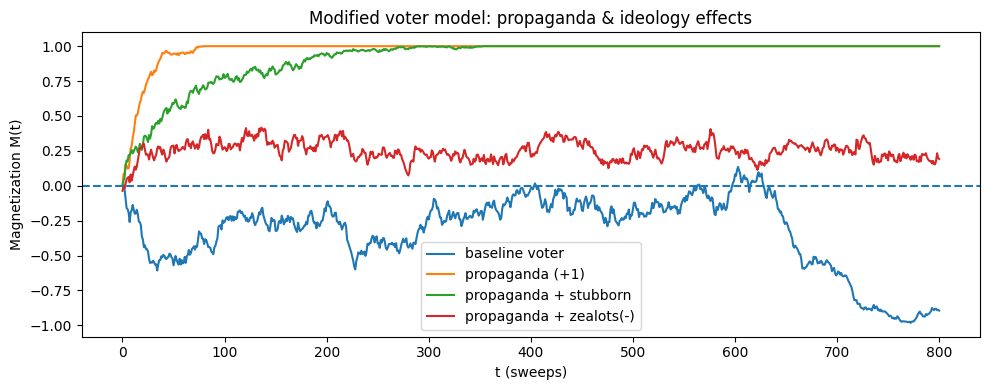

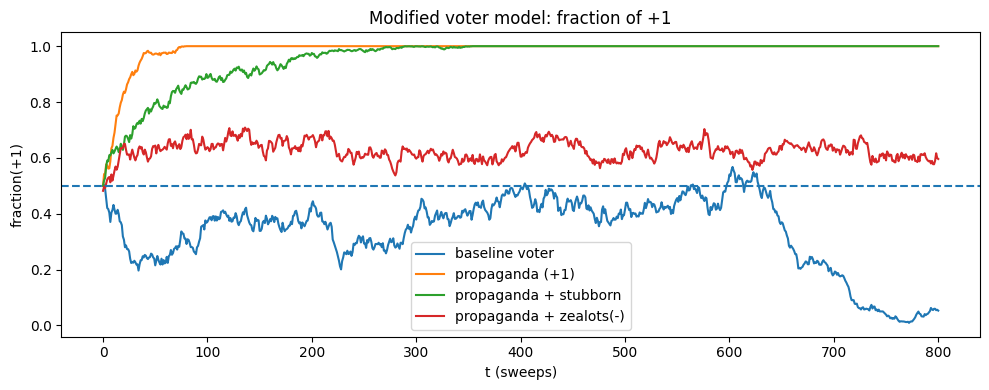

In [22]:
def simulate_voter_with_effects(
    G,
    T=5000,
    init_plus_frac=0.5,
    prop_prob=0.05,
    prop_target=+1,
    stubborn_frac=0.10,
    stubborn_strength=0.90,
    zealot_plus_frac=0.00,
    zealot_minus_frac=0.00,
    update_mode="sweep",
    seed=42,
    return_state=False
):
    rng = np.random.default_rng(seed)

    nodes = list(G.nodes())
    N = len(nodes)
    idx = {u: i for i, u in enumerate(nodes)}
    neigh = [np.fromiter((idx[v] for v in G.neighbors(u)), dtype=int) for u in nodes]

    state = np.full(N, -1, dtype=np.int8)
    n_plus = int(round(init_plus_frac * N))
    if n_plus > 0:
        plus_idx = rng.choice(N, size=n_plus, replace=False)
        state[plus_idx] = 1

    zealot_plus = np.zeros(N, dtype=bool)
    zealot_minus = np.zeros(N, dtype=bool)

    n_zp = int(round(zealot_plus_frac * N))
    n_zm = int(round(zealot_minus_frac * N))
    if n_zp + n_zm > 0:
        all_idx = np.arange(N)
        rng.shuffle(all_idx)
        zp_idx = all_idx[:n_zp]
        zm_idx = all_idx[n_zp:n_zp + n_zm]
        zealot_plus[zp_idx] = True
        zealot_minus[zm_idx] = True
        state[zealot_plus] = 1
        state[zealot_minus] = -1

    fixed = zealot_plus | zealot_minus

    stubborn = np.zeros(N, dtype=bool)
    n_st = int(round(stubborn_frac * N))
    if n_st > 0:
        candidates = np.where(~fixed)[0]
        if candidates.size > 0:
            st_idx = rng.choice(candidates, size=min(n_st, candidates.size), replace=False)
            stubborn[st_idx] = True

    M = np.empty(T + 1, dtype=float)
    frac_plus = np.empty(T + 1, dtype=float)
    M[0] = state.mean()
    frac_plus[0] = (state == 1).mean()

    def is_consensus(x):
        s = int(x.sum())
        return (s == N) or (s == -N)

    t_consensus = 0 if is_consensus(state) else None

    if update_mode not in {"async", "sweep"}:
        raise ValueError("update_mode must be 'async' or 'sweep'")
    if prop_target not in (-1, 1):
        raise ValueError("prop_target must be +1 or -1")

    def one_update():
        i = rng.integers(0, N)
        if fixed[i]:
            return

        if rng.random() < prop_prob:
            proposed = prop_target
        else:
            nb = neigh[i]
            if nb.size == 0:
                return
            j = nb[rng.integers(0, nb.size)]
            proposed = int(state[j])

        if stubborn[i] and proposed != state[i]:
            if rng.random() < stubborn_strength:
                return

        state[i] = proposed

    for t in range(1, T + 1):
        if update_mode == "async":
            one_update()
        else:  # sweep
            for _ in range(N):
                one_update()

        M[t] = state.mean()
        frac_plus[t] = (state == 1).mean()
        if t_consensus is None and is_consensus(state):
            t_consensus = t

    if return_state:
        return M, frac_plus, t_consensus, state, stubborn, fixed
    return M, frac_plus, t_consensus


if __name__ == "__main__":
    N = 2000
    G = nx.erdos_renyi_graph(N, 0.01, seed=1)

    T = 800
    seed = 7

    M0, f0, tC0 = simulate_voter_with_effects(
        G, T=T, seed=seed,
        prop_prob=0.0,
        stubborn_frac=0.0,
        zealot_plus_frac=0.0,
        zealot_minus_frac=0.0,
        update_mode="sweep"
    )

    Mp, fp, tCp = simulate_voter_with_effects(
        G, T=T, seed=seed,
        prop_prob=0.05, prop_target=+1,
        stubborn_frac=0.0,
        update_mode="sweep"
    )

    Mps, fps, tCps = simulate_voter_with_effects(
        G, T=T, seed=seed,
        prop_prob=0.05, prop_target=+1,
        stubborn_frac=0.15, stubborn_strength=0.95,
        update_mode="sweep"
    )

    Mpz, fpz, tCpz = simulate_voter_with_effects(
        G, T=T, seed=seed,
        prop_prob=0.05, prop_target=+1,
        zealot_minus_frac=0.03,
        update_mode="sweep"
    )

    print("Consensus times (in sweeps):")
    print("baseline:", tC0, " propaganda:", tCp, " propaganda+stubborn:", tCps, " propaganda+zealots:", tCpz)

    plt.figure(figsize=(10,4))
    plt.plot(M0, label="baseline voter")
    plt.plot(Mp, label="propaganda (+1)")
    plt.plot(Mps, label="propaganda + stubborn")
    plt.plot(Mpz, label="propaganda + zealots(-)")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("t (sweeps)")
    plt.ylabel("Magnetization M(t)")
    plt.title("Modified voter model: propaganda & ideology effects")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(f0, label="baseline voter")
    plt.plot(fp, label="propaganda (+1)")
    plt.plot(fps, label="propaganda + stubborn")
    plt.plot(fpz, label="propaganda + zealots(-)")
    plt.axhline(0.5, linestyle="--")
    plt.xlabel("t (sweeps)")
    plt.ylabel("fraction(+1)")
    plt.title("Modified voter model: fraction of +1")
    plt.legend()
    plt.tight_layout()
    plt.show()